## **Authors**: Layolin Jesudhass & Isidro De Loera
## **Team**: [Emerging Solutions](https://moma.corp.google.com/team/1704448620054?prev_event_id=XtubZ9_nON-VpMYPvfmV4QI&hq=type%3Apeople)

## Imports

In [ ]:
!pip install --upgrade --user google-cloud-aiplatform

from google import genai
from google.genai import types
from google.cloud import aiplatform, storage
from google.cloud.aiplatform.gapic import PredictResponse
from google.colab import auth

import base64
import io
import re
import timeit
import os
import json
from pathlib import Path
from typing import Any, Dict, List, Generator
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
# --------------------------------------------------
# Authenticate your Colab session with GCP
from google.colab import auth
auth.authenticate_user()
print("Authenticated with Google Cloud")
# --------------------------------------------------


Authenticated with Google Cloud


## Helper Functions


In [ ]:
#Core Helper Functions for GCS scanning and image display

# GCS‑scanning + debug prints

def get_mime_type(uri: str) -> str:
    ext = os.path.splitext(uri)[1].lower()
    if ext == ".png":
        return "image/png"
    elif ext in (".jpg", ".jpeg"):
        return "image/jpeg"
    else:
        raise ValueError(f"Unsupported extension: {ext}")

def discover_product_batches(input_gcs_uri: str) -> Generator[Dict[str, object], None, None]:
    """
    Yields dicts with:
      - product_folder (e.g. "product_5")
      - image_parts   (List[types.Part])
      - product_uris  (List[str])
    """
    m = re.match(r"gs://([^/]+)/(.+?)/?$", input_gcs_uri)
    if not m:
        raise ValueError(f"Invalid GCS URI: {input_gcs_uri}")
    bucket_name, base_prefix = m.groups()
    prefix = base_prefix.rstrip("/") + "/"
    client = storage.Client()
    print(f"🔍 Scanning bucket={bucket_name} prefix={prefix}")

    # fetch all blobs under prefix
    blobs = list(client.list_blobs(bucket_name, prefix=prefix))
    print(f"  • Found {len(blobs)} total objects under {prefix}")

    # group by first‑level folder name
    folder_map: Dict[str, List[storage.blob.Blob]] = {}
    for b in blobs:
        rel = b.name[len(prefix):]  # e.g. "product_5/thermos_1.png"
        parts = rel.split("/", 1)
        if len(parts) != 2:
            continue
        folder, filename = parts
        if not filename.lower().endswith((".png", ".jpg", ".jpeg")):
            continue
        folder_map.setdefault(folder, []).append(b)

    print(f"  • Discovered product folders: {list(folder_map.keys())}")

    for folder, blob_list in folder_map.items():
        # sort & take up to 3
        blob_list.sort(key=lambda b: os.path.basename(b.name))
        blob_list = blob_list[:3]

        uris = [f"gs://{bucket_name}/{b.name}" for b in blob_list]
        parts = [
            types.Part(
                file_data=types.FileData(file_uri=uri, mime_type=get_mime_type(uri))
            )
            for uri in uris
        ]

        yield {
            "product_folder": folder,
            "image_parts":   parts,
            "product_uris":  uris,
        }

# Display helpers
def download_gcs_image_bytes(uri: str) -> bytes:
    m = re.match(r"gs://([^/]+)/(.*)", uri)
    if not m:
        raise ValueError(f"Invalid GCS URI: {uri}")
    bucket_name, obj = m.groups()
    client = storage.Client()
    return client.bucket(bucket_name).blob(obj).download_as_bytes()

def prediction_to_pil_image(pred: PredictResponse, size=(640, 640)) -> Image.Image:
    b64 = pred["bytesBase64Encoded"]
    data = base64.b64decode(b64)
    img = Image.open(io.BytesIO(data))
    img.thumbnail(size)
    return img

def display_row(items: List[Any], figsize=(12, 4)):
    if not items:
        print("No items to display.")
        return
    fig, axes = plt.subplots(1, len(items), figsize=figsize)
    if len(items) == 1:
        axes = [axes]
    for ax, it in zip(axes, items):
        if isinstance(it, Image.Image):
            ax.imshow(it)
        elif isinstance(it, dict) and "bytesBase64Encoded" in it:
            ax.imshow(prediction_to_pil_image(it))
        else:
            ax.text(0.5, 0.5, str(it), ha="center", va="center", wrap=True)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# generate() with fixed SafetySetting keyword args
def generate(image_parts: List[types.Part]) -> Dict[str, str]:
    import json, re
    from google import genai
    from google.genai import types

    client = genai.Client(
        vertexai=True,
        project="consumer-genai-experiments",
        location="global",
    )

    user_instr = types.Part.from_text(text="""
Analyze the provided images of a single product (up to 3). First, identify and describe the product in accurate, natural language: focus on material, color, shape, form, pattern, and distinctive design features.

Then, determine a visually appropriate and realistic background or scene where the product would naturally appear and look appealing. Base this on the product’s style and category — for example, place a desk lamp in a home office, or a sneaker in a modern studio.

DO NOT GENERATE PEOPLE/CHILDREN
Your output should be returned as a JSON object in the format below:
{
  "Prompt": "<rich description of product and proposed scene>",
  "product_description": "<just the product, no scene>"
}

Do not reference the original image’s background or lighting.
Do not use placeholders like “in a nice room” — be specific about the setting (e.g., “in a sunlit bohemian-style bedroom with woven textures and indoor plants”).
""")

    system_instr = types.Part.from_text(text="""
Role:
You are an expert visual analyst and prompt engineer for AI-based image generation. Your task is to analyze up to 3 input images of the same product, and generate a single, high-quality prompt suitable for AI-driven product image recontextualization.

Your objectives are twofold:

Describe the product accurately: Identify product category, form, material, texture, color, patterns, and notable design features.

Propose a compelling background/scene: Select a suitable environment in which the product would naturally and attractively appear — based on its likely usage, aesthetic, and category.

DO NOT GENERATE PEOPLE/CHILDREN

Input:
Up to 3 images of the same product (e.g., different angles or lighting).
No metadata, no background descriptions provided — just images.

Output Format:
Return a JSON object in this structure:
{
  "Prompt": "<natural language prompt for recontextualized image generation>",
  "product_description": "<just the product description, no scene>"
}""")

    contents = [ types.Content(role="user", parts=[user_instr, *image_parts]) ]
    config = types.GenerateContentConfig(
        temperature=0.2,
        top_p=0.95,
        max_output_tokens=8192,
        safety_settings=[
            types.SafetySetting(category="HARM_CATEGORY_HATE_SPEECH", threshold="OFF"),
            types.SafetySetting(category="HARM_CATEGORY_DANGEROUS_CONTENT", threshold="OFF"),
            types.SafetySetting(category="HARM_CATEGORY_SEXUALLY_EXPLICIT", threshold="OFF"),
            types.SafetySetting(category="HARM_CATEGORY_HARASSMENT", threshold="OFF"),
        ],
        system_instruction=[system_instr],
        thinking_config=types.ThinkingConfig(thinking_budget=0)
    )

    output = ""
    for chunk in client.models.generate_content_stream(
        model="gemini-2.5-flash", contents=contents, config=config
    ):
        output += chunk.text

    clean = output.strip()
    clean = re.sub(r"^```(?:\w+)?\n","", clean)
    clean = re.sub(r"\n```$","", clean)
    return json.loads(clean)


# call_product_recontext()
def call_product_recontext(
    image_bytes_list=None,
    image_uris_list=None,
    prompt=None,
    product_description=None,
    disable_prompt_enhancement=True,
    sample_count=1,
    base_steps=None,
    safety_setting=None,
    person_generation=None,
) -> PredictResponse:
    inst: Dict[str, Any] = {"productImages": []}
    if image_uris_list:
        for uri in image_uris_list:
            inst["productImages"].append({"image": {"gcsUri": uri}})
    if not inst["productImages"]:
        raise ValueError("No product images provided.")
    if product_description:
        inst["productImages"][0]["productConfig"] = {"productDescription": product_description}
    if prompt:
        inst["prompt"] = prompt

    params = {"sampleCount": sample_count}
    if disable_prompt_enhancement: params["enhancePrompt"] = False
    if safety_setting:       params["safetySetting"] = safety_setting
    if person_generation:    params["personGeneration"] = person_generation
    if base_steps:           params["baseSteps"] = base_steps

    start = timeit.default_timer()
    resp = predict_client.predict(
        endpoint=model_endpoint,
        instances=[inst],
        parameters=params,
    )
    print(f"Recontext took {timeit.default_timer()-start:.2f}s")
    return resp

# save & upload helper
def save_and_upload_recontext_image(
    prediction_response,
    product_folder: str,
    output_bucket_name: str,
    output_base_prefix: str = "walmart/product_images_output",
    image_index: int = 0,
):
    out_pref = f"{output_base_prefix}/{product_folder}"

    if isinstance(prediction_response, list):
        prediction_response = prediction_response[0]
    img = prediction_to_pil_image(prediction_response)

    local = f"{product_folder}_output_{image_index}.jpg"
    img.convert("RGB").save(local, format="JPEG")
    print(f"Saved local: {local}")

    client = storage.Client()
    bucket = client.bucket(output_bucket_name)
    # ensure folder exists
    if not list(bucket.list_blobs(prefix=out_pref+"/")):
        bucket.blob(out_pref+"/").upload_from_string("", content_type="application/x-folder")
        print(f"🗂 Created folder gs://{output_bucket_name}/{out_pref}/")

    dst = bucket.blob(f"{out_pref}/{local}")
    dst.upload_from_filename(local, content_type="image/jpeg")
    print(f"Uploaded to gs://{output_bucket_name}/{out_pref}/{local}")

## Initialize Vertex AI Client

In [ ]:
# Init clients
PROJECT_ID = "consumer-genai-experiments"
LOCATION   = "us-central1"

aiplatform.init(project=PROJECT_ID, location=LOCATION)
predict_client = aiplatform.gapic.PredictionServiceClient(
    client_options={"api_endpoint": f"{LOCATION}-aiplatform.googleapis.com"}
)
model_endpoint = (
    f"projects/{PROJECT_ID}/locations/{LOCATION}"
    + "/publishers/google/models/imagen-product-recontext-preview-06-30"
)
print("Prediction client ready")


Prediction client ready


# Sequential Run


Process started at: 2025-07-25 18:11:37
🔍 Scanning bucket=id_test_bucket prefix=walmart/product_images_input/
  • Found 63 total objects under walmart/product_images_input/
  • Discovered product folders: ['product_1', 'product_10', 'product_11', 'product_12', 'product_13', 'product_14', 'product_15', 'product_16', 'product_17', 'product_18', 'product_19', 'product_2', 'product_20', 'product_3', 'product_4', 'product_5', 'product_6', 'product_7', 'product_8', 'product_9']

Total product folders discovered: 20

=== Processing product_1 ===


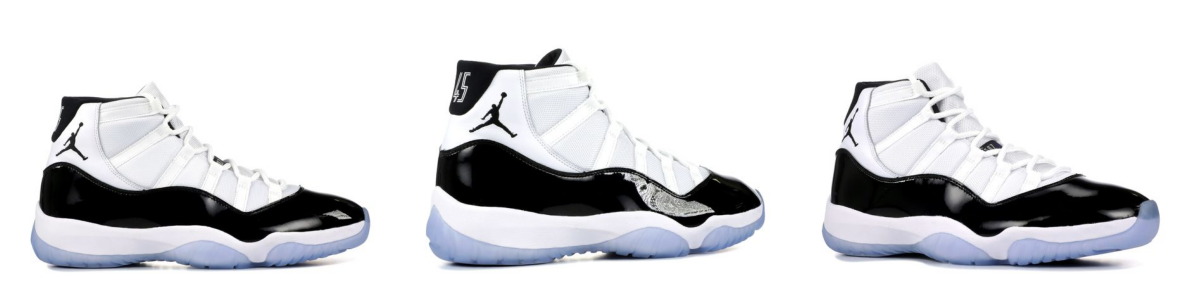

Prompt: A high-top athletic sneaker, primarily white and black, featuring a prominent glossy black patent leather mudguard that wraps around the entire base of the shoe. The upper is constructed from white mesh and leather, with white laces and a black tongue. A black Jumpman logo is visible on the side ankle. The sole is white with a translucent icy blue outsole. The sneaker is displayed on a polished hardwood basketball court, with subtle reflections on the floor, under bright arena lighting.
Desc:   A high-top athletic sneaker, primarily white and black, featuring a prominent glossy black patent leather mudguard that wraps around the entire base of the shoe. The upper is constructed from white mesh and leather, with white laces and a black tongue. A black Jumpman logo is visible on the side ankle. The sole is white with a translucent icy blue outsole.


KeyboardInterrupt: 

In [ ]:
# Sequential one by one

from datetime import datetime
import io
from PIL import Image

# Define constants
INPUT_PREFIX = "gs://id_test_bucket/walmart/product_images_input"
OUTPUT_BUCKET = "id_test_bucket"

# Start time
start_time = datetime.now()
print(f"\nProcess started at: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")

# Discover batches
batches = list(discover_product_batches(INPUT_PREFIX))
print(f"\nTotal product folders discovered: {len(batches)}")

if not batches:
    raise RuntimeError("No product batches found—check your GCS path & permissions!")

# Process each batch
for batch in batches:
    print(f"\n=== Processing {batch['product_folder']} ===")

    # Preview
    imgs = [Image.open(io.BytesIO(download_gcs_image_bytes(u))) for u in batch["product_uris"]]
    display_row(imgs)

    # Generate prompt & description
    gen = generate(batch["image_parts"])
    print("Prompt:", gen["Prompt"])
    print("Desc:  ", gen["product_description"])

    # Recontextualize
    resp = call_product_recontext(
        prompt=gen["Prompt"],
        product_description=gen["product_description"],
        image_uris_list=batch["product_uris"],
        disable_prompt_enhancement=False,
        sample_count=1,
        safety_setting="block_low_and_above",
        person_generation="allow_adult",
    )

    # Display & upload
    preds = list(resp.predictions)
    display_row(preds)
    for i, p in enumerate(preds):
        save_and_upload_recontext_image(
            p,
            batch["product_folder"],
            OUTPUT_BUCKET,
            image_index=i
        )

# End time
end_time = datetime.now()
duration = end_time - start_time
print(f"\nProcess completed at: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"⏱Total time taken: {duration}")


# Parallel threads


🔄 Process started at: 2025-07-28 16:32:01
🔍 Scanning bucket=id_test_bucket prefix=walmart/product_images_input/
  • Found 63 total objects under walmart/product_images_input/
  • Discovered product folders: ['product_1', 'product_10', 'product_11', 'product_12', 'product_13', 'product_14', 'product_15', 'product_16', 'product_17', 'product_18', 'product_19', 'product_2', 'product_20', 'product_3', 'product_4', 'product_5', 'product_6', 'product_7', 'product_8', 'product_9']

Total product folders discovered: 20

=== Processing product_1 ===

=== Processing product_10 ===

=== Processing product_11 ===

=== Processing product_12 ===

=== Processing product_13 ===


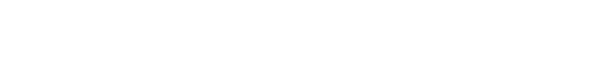

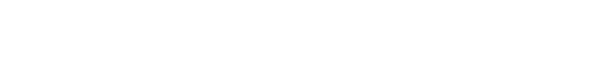

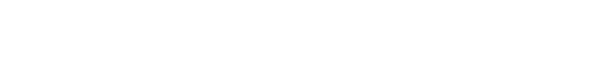

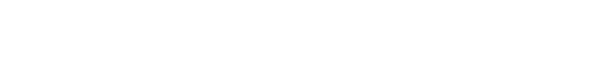

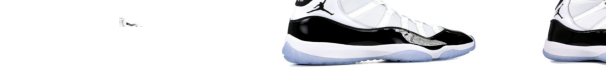

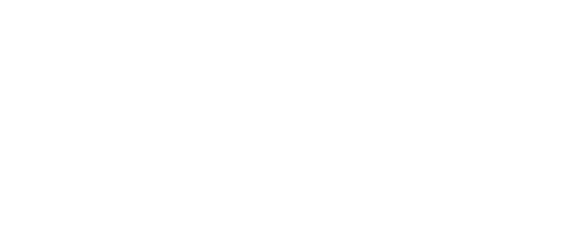

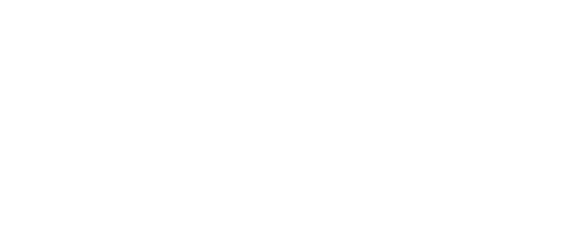

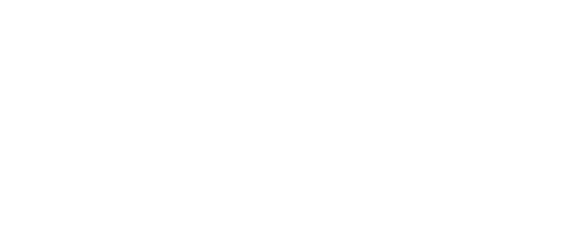

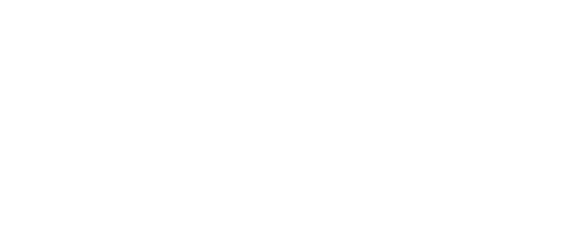

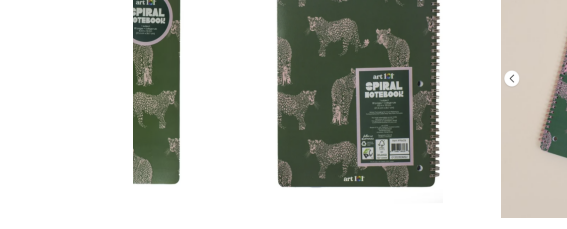

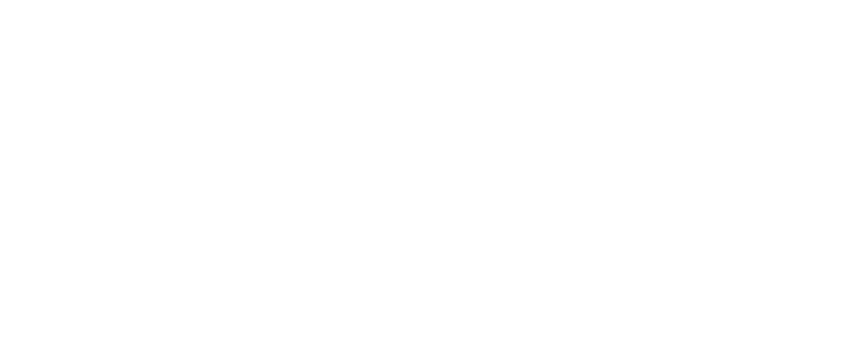

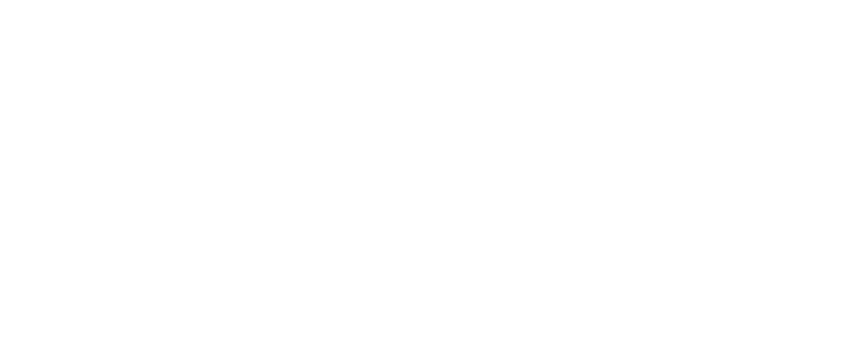

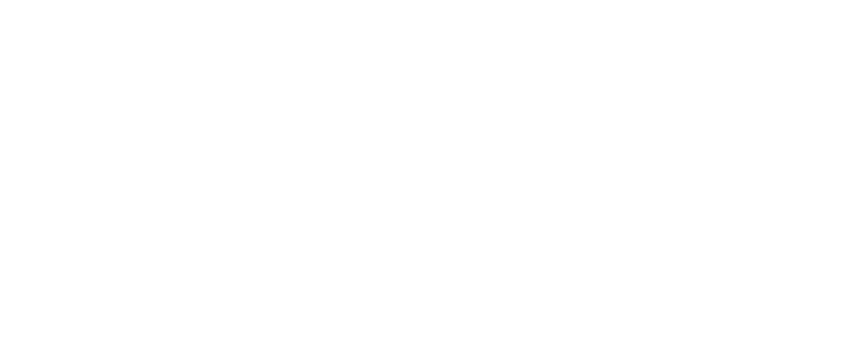

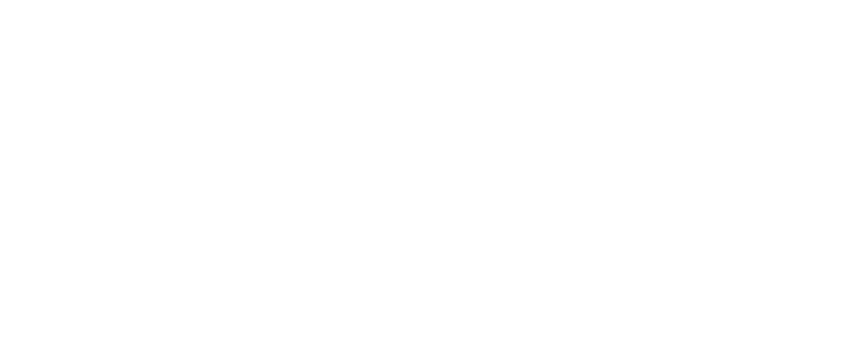

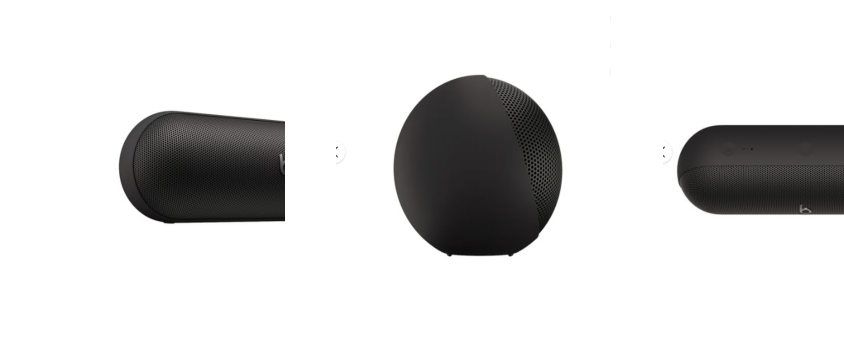

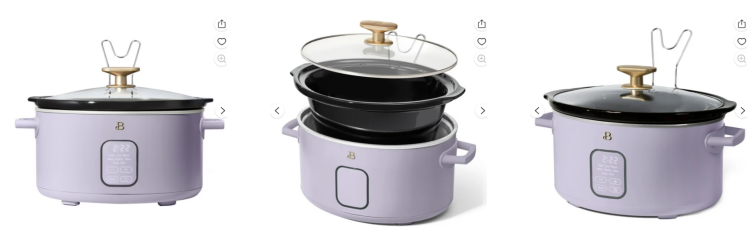

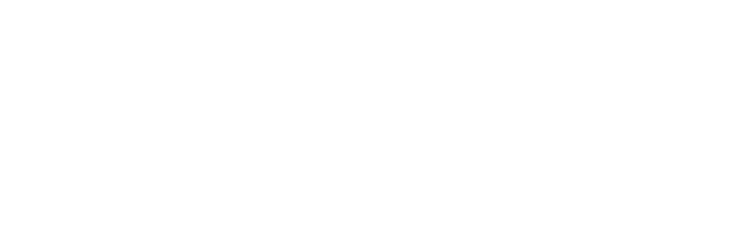

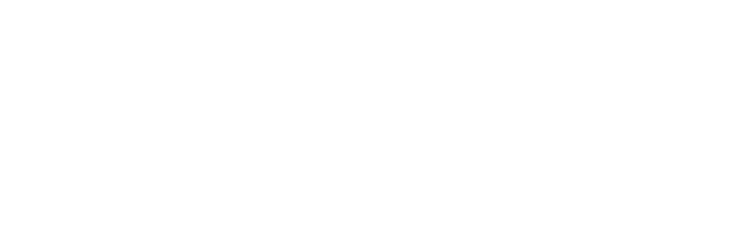

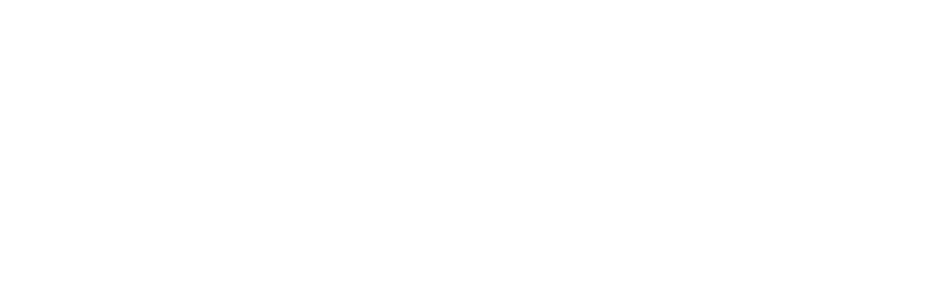

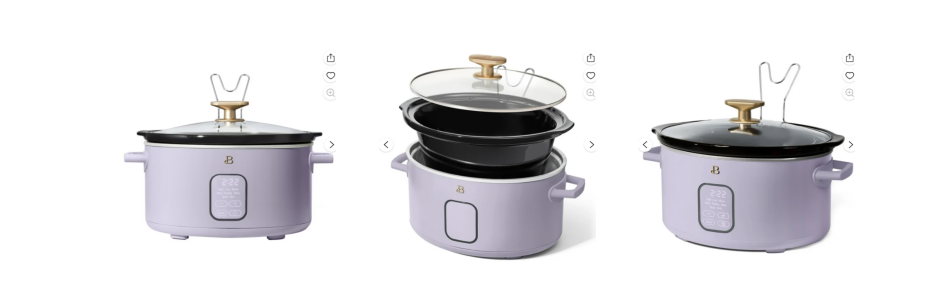

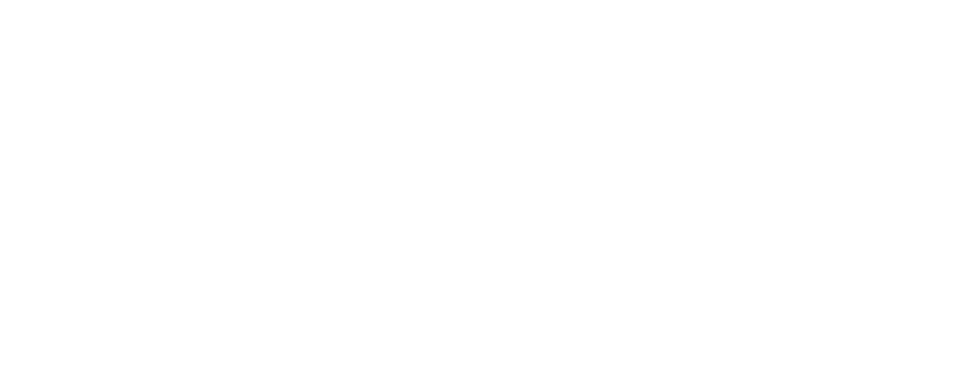

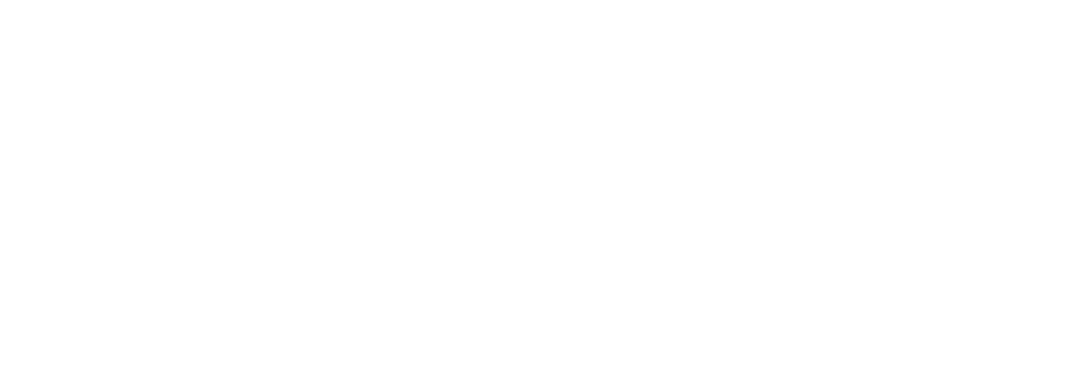

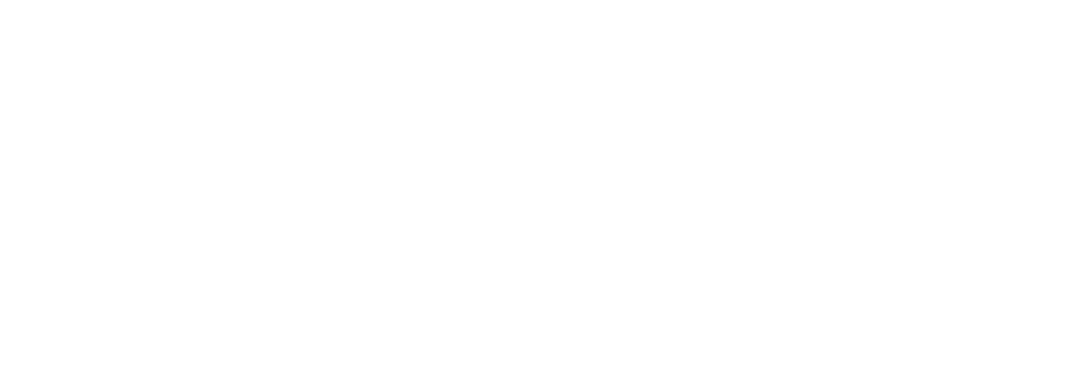

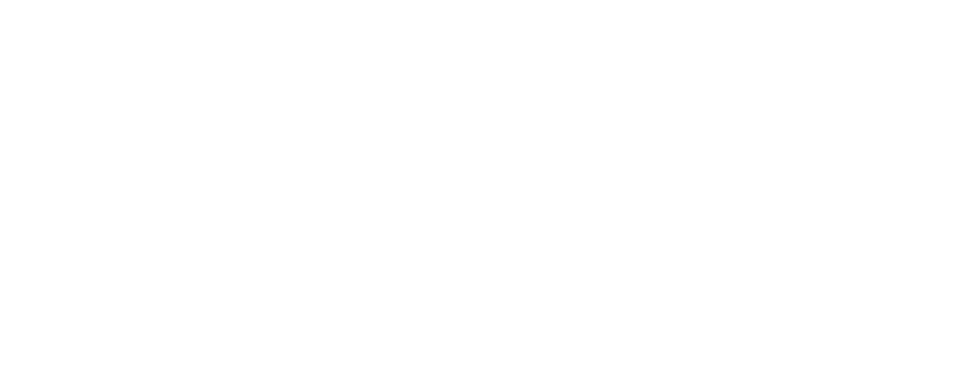

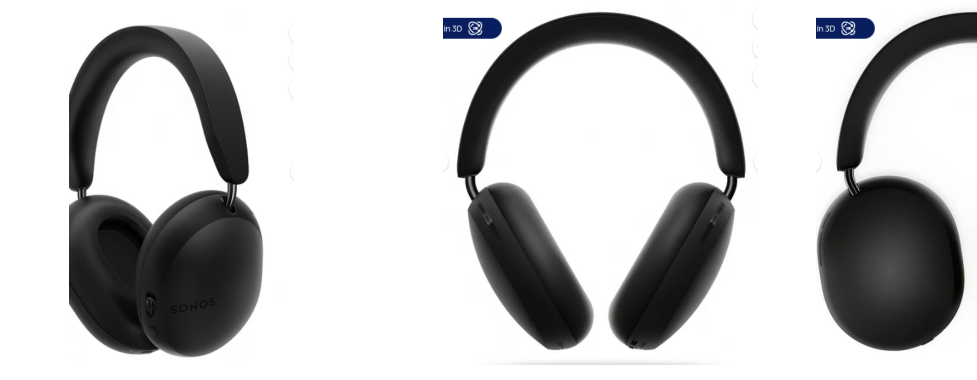

Prompt: A pair of sleek, matte black over-ear headphones with a minimalist design, featuring a smooth, rounded headband and oval-shaped earcups. The 'SONOS' logo is subtly debossed on the side of one earcup. The headphones are resting on a polished dark wood desk in a modern home office, with a soft, warm light filtering in from a large window, illuminating a few minimalist desk accessories like a sleek laptop and a small potted succulent.
Desc:   A pair of sleek, matte black over-ear headphones with a minimalist design, featuring a smooth, rounded headband and oval-shaped earcups. The 'SONOS' logo is subtly debossed on the side of one earcup.
Prompt: A modern, oval-shaped slow cooker in a matte lavender finish, featuring a black ceramic insert, a clear glass lid with a gold-toned knob, and a digital display with touch controls. It has integrated side handles and a gold 'B' logo on the front. The slow cooker is positioned on a light wood kitchen countertop, surrounded by fresh herbs in

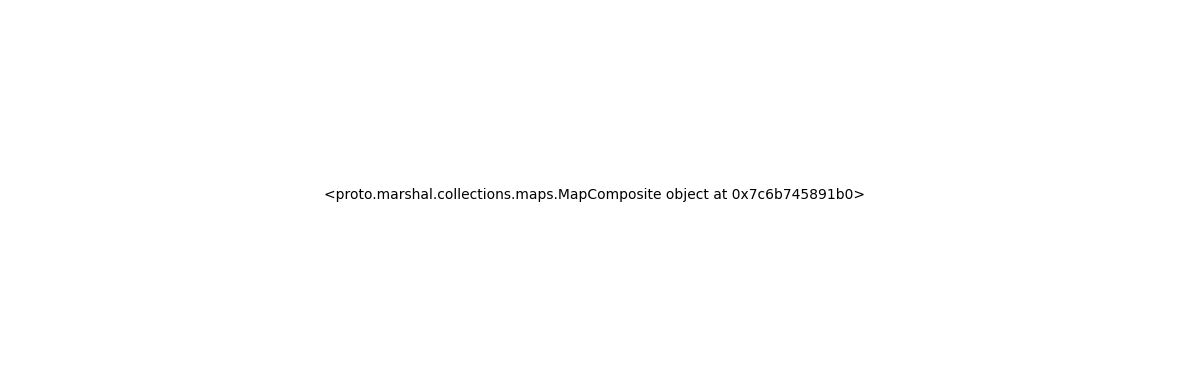

Saved local: product_12_output_0.jpg
Uploaded to gs://id_test_bucket/walmart/product_images_output/product_12/product_12_output_0.jpg

=== Processing product_14 ===


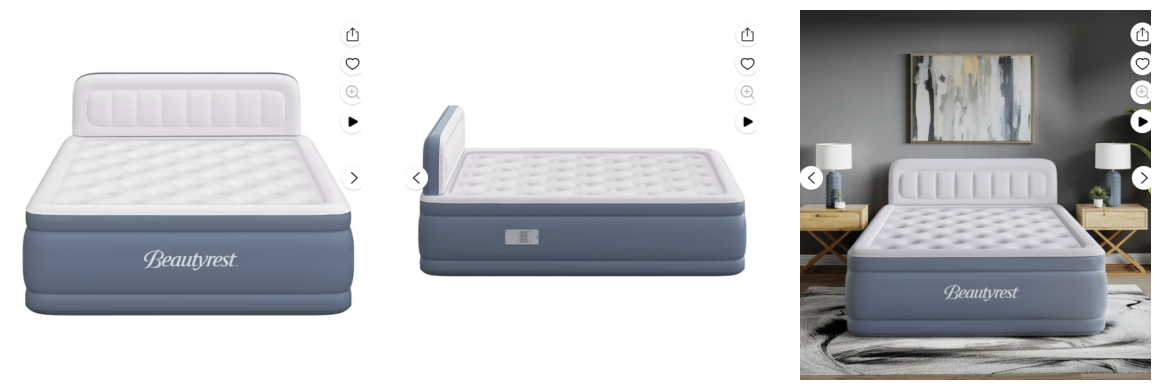

Recontext took 16.27s


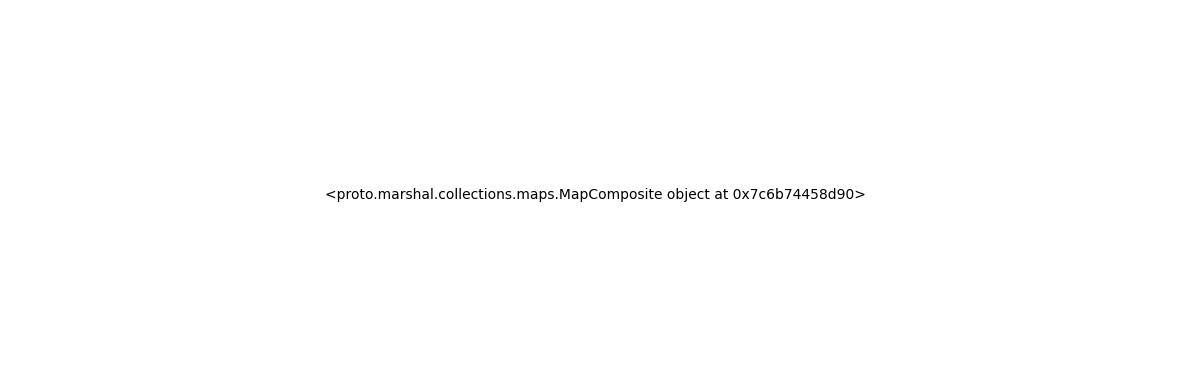

Saved local: product_13_output_0.jpg
Recontext took 15.38s


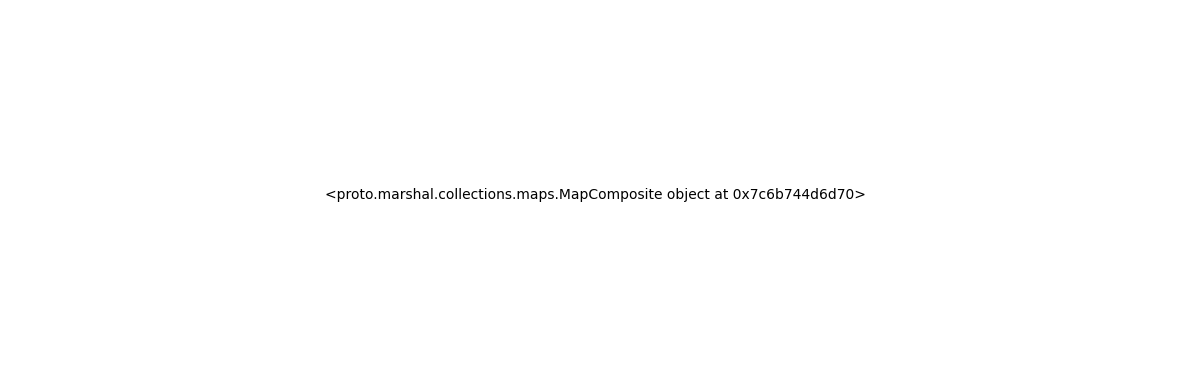

Uploaded to gs://id_test_bucket/walmart/product_images_output/product_13/product_13_output_0.jpg

=== Processing product_15 ===
Saved local: product_1_output_0.jpg
Uploaded to gs://id_test_bucket/walmart/product_images_output/product_1/product_1_output_0.jpg

=== Processing product_16 ===


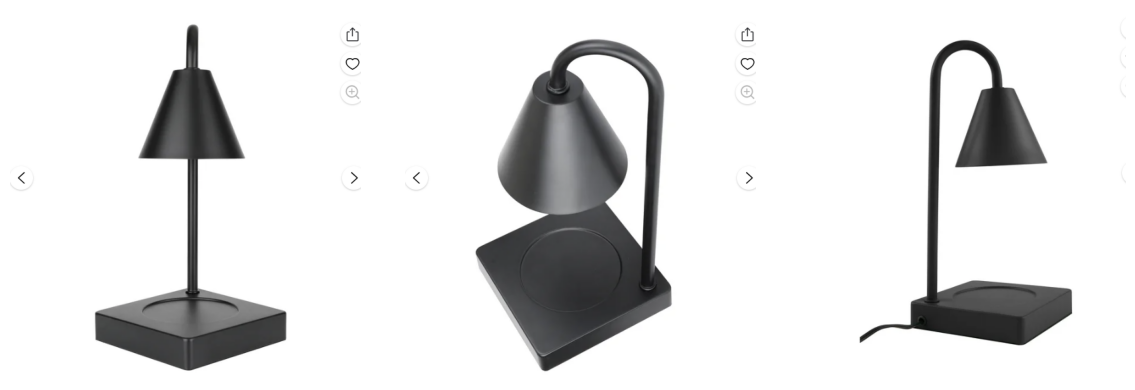

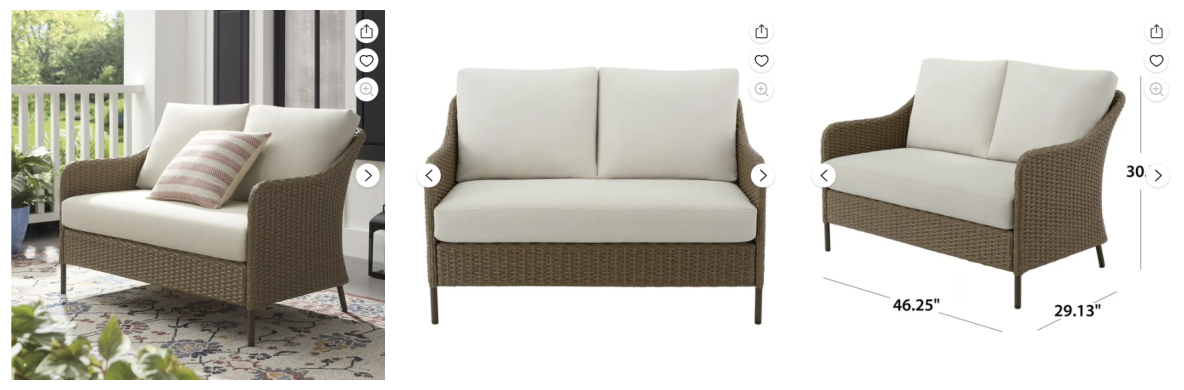

Recontext took 16.73s


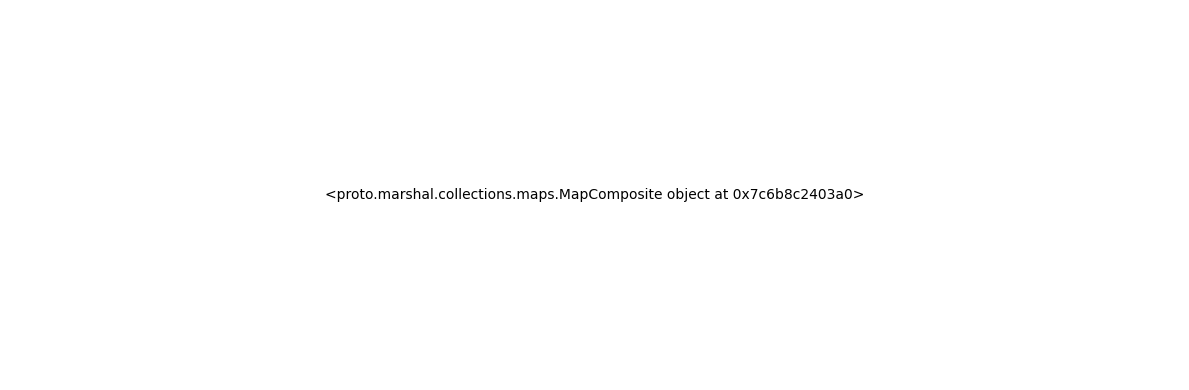

Saved local: product_10_output_0.jpg
Uploaded to gs://id_test_bucket/walmart/product_images_output/product_10/product_10_output_0.jpg

=== Processing product_17 ===
Prompt: A large, rectangular inflatable air mattress with a built-in headboard, featuring a two-tone design with a light gray top sleeping surface and a darker blue-gray base. The top surface has a quilted or tufted appearance with circular indentations, while the headboard is vertically ribbed. The brand name 'Beautyrest' is prominently displayed in white script on the side of the base. The air mattress is placed in a modern guest bedroom with light-colored hardwood floors, a minimalist nightstand with a small plant, and soft, indirect lighting from a window.
Desc:   A large, rectangular inflatable air mattress with a built-in headboard, featuring a two-tone design with a light gray top sleeping surface and a darker blue-gray base. The top surface has a quilted or tufted appearance with circular indentations, while the hea

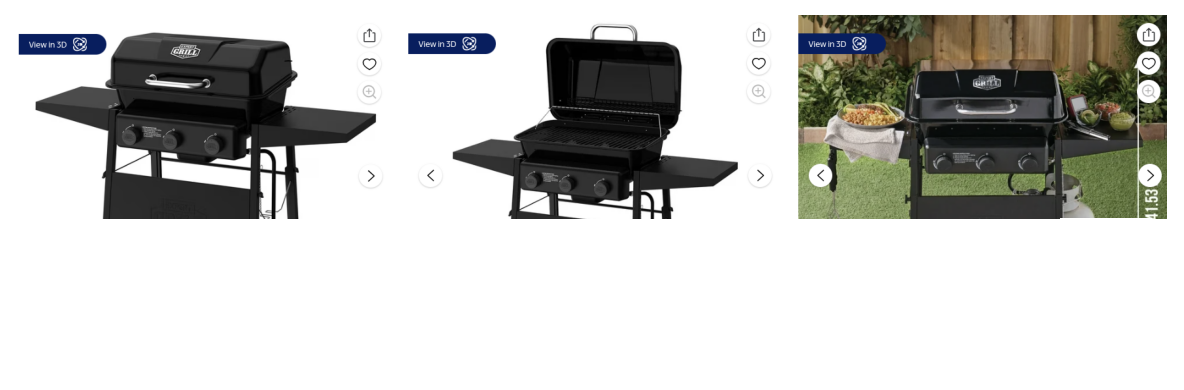

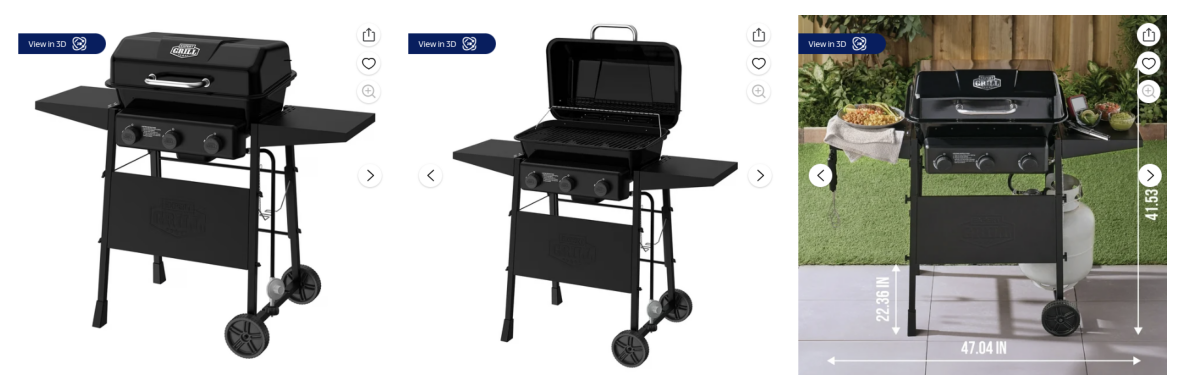

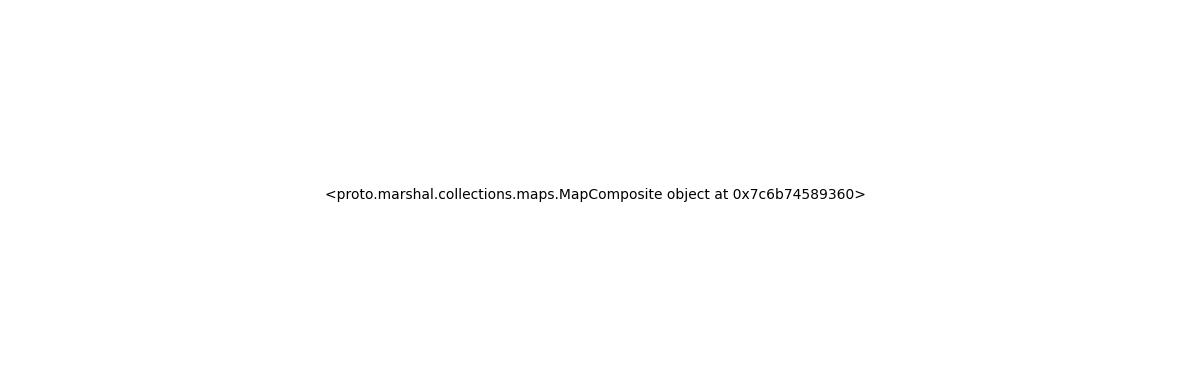

Saved local: product_11_output_0.jpg
Prompt: A sleek, modern matte black candle warmer with a square base, a circular indentation for a candle, and a curved arm supporting a conical shade, casting a warm glow over a cozy reading nook. The nook features a plush armchair, a stack of books on a small side table, and soft ambient lighting from a nearby window, creating a serene and inviting atmosphere.
Desc:   A sleek, modern matte black candle warmer with a square base, a circular indentation for a candle, and a curved arm supporting a conical shade.
Uploaded to gs://id_test_bucket/walmart/product_images_output/product_11/product_11_output_0.jpg

=== Processing product_18 ===


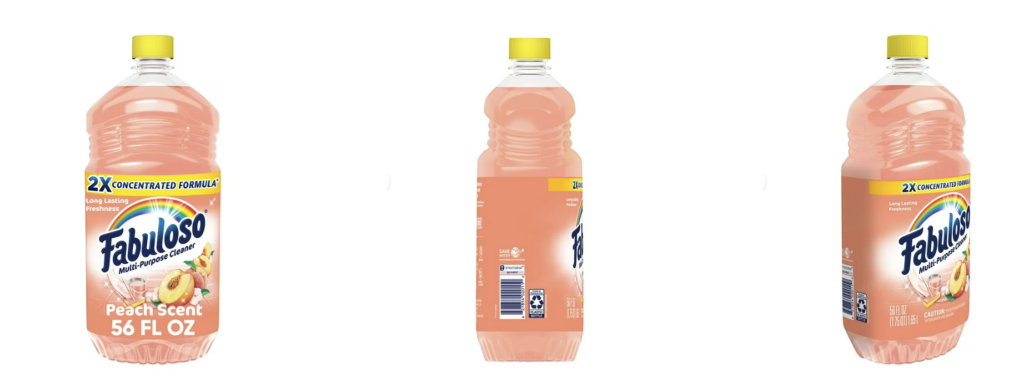

Prompt: A two-seater outdoor loveseat featuring a durable, weather-resistant brown wicker frame with a tightly woven texture and gently curved armrests. It is fitted with plush, off-white upholstered cushions for both the seat and back, providing a comfortable and inviting appearance. The loveseat stands on four slender, dark brown metal legs. The loveseat is placed on a spacious, sun-drenched patio with terracotta tiles, surrounded by lush green potted plants and a vibrant bougainvillea vine climbing a white trellis in the background. The scene evokes a relaxed, Mediterranean-inspired outdoor living space.
Desc:   A two-seater outdoor loveseat featuring a durable, weather-resistant brown wicker frame with a tightly woven texture and gently curved armrests. It is fitted with plush, off-white upholstered cushions for both the seat and back, providing a comfortable and inviting appearance. The loveseat stands on four slender, dark brown metal legs.
Prompt: A compact, black gas grill with

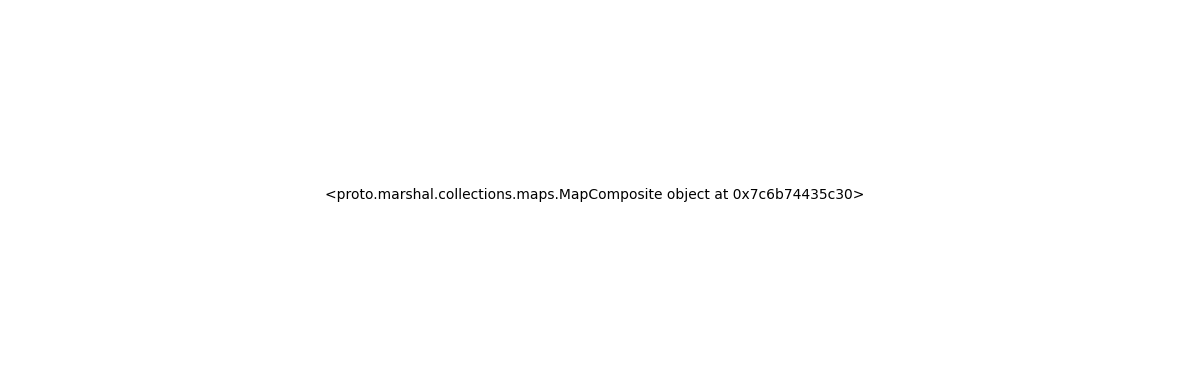

Saved local: product_15_output_0.jpg
Uploaded to gs://id_test_bucket/walmart/product_images_output/product_15/product_15_output_0.jpg

=== Processing product_19 ===


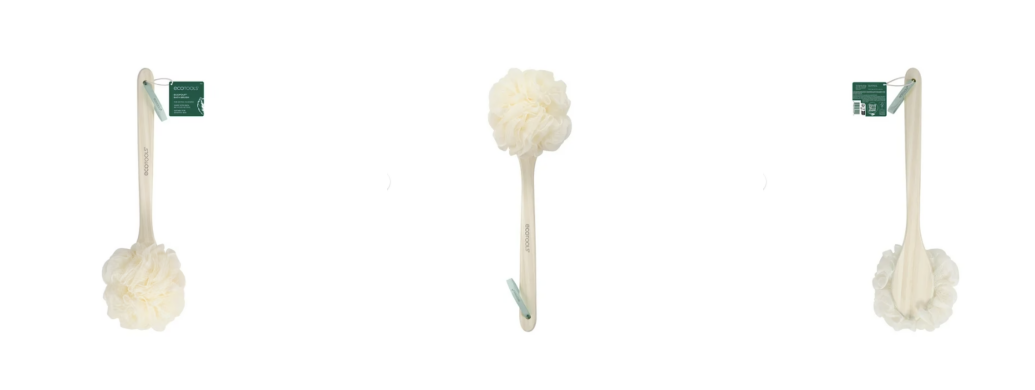

Recontext took 15.09s


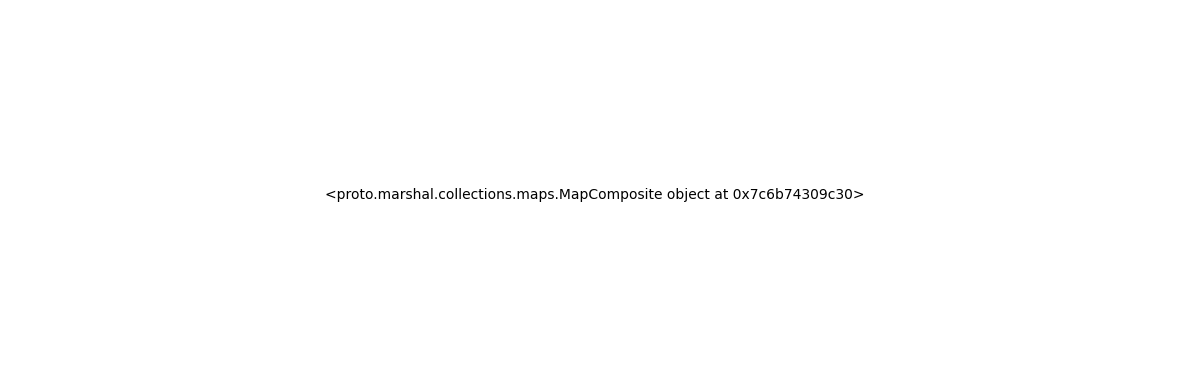

Saved local: product_14_output_0.jpg
Uploaded to gs://id_test_bucket/walmart/product_images_output/product_14/product_14_output_0.jpg

=== Processing product_2 ===
Recontext took 12.51s


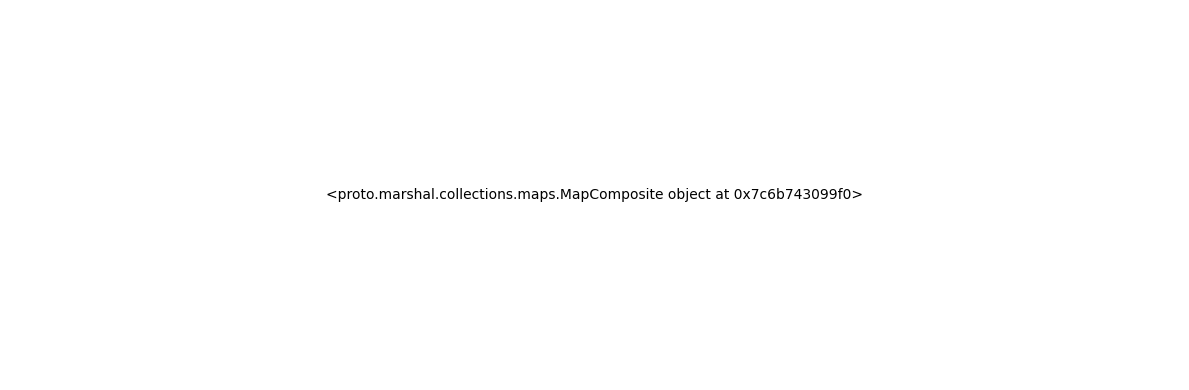

Saved local: product_17_output_0.jpg
Recontext took 12.89s
Prompt: A long-handled bath brush with a light beige wooden handle and a fluffy, cream-colored mesh loofah head, hanging on a hook in a minimalist, spa-like bathroom with white subway tiles and a natural wood vanity. Soft, diffused lighting highlights the texture of the loofah.
Desc:   A long-handled bath brush featuring a light beige wooden handle with a smooth finish and a fluffy, cream-colored mesh loofah head. The handle has a subtle curve and a small hole at the end for hanging.
Uploaded to gs://id_test_bucket/walmart/product_images_output/product_17/product_17_output_0.jpg

=== Processing product_20 ===


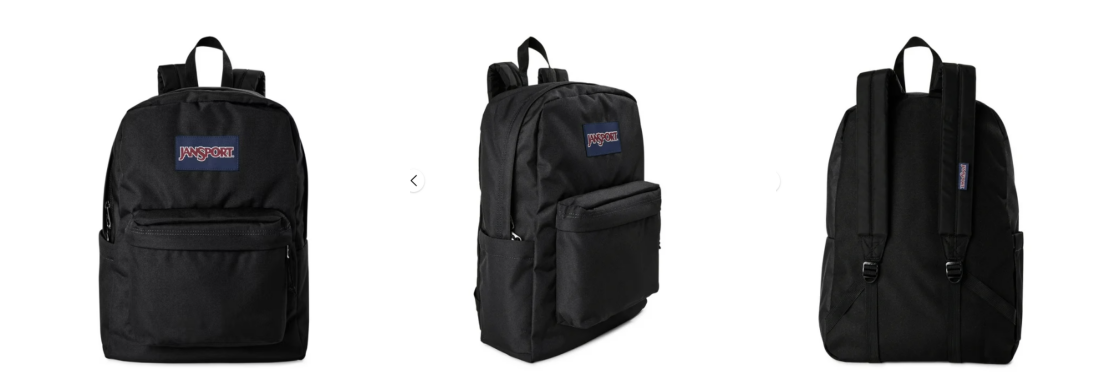

Saved local: product_16_output_0.jpg
Uploaded to gs://id_test_bucket/walmart/product_images_output/product_16/product_16_output_0.jpg

=== Processing product_3 ===


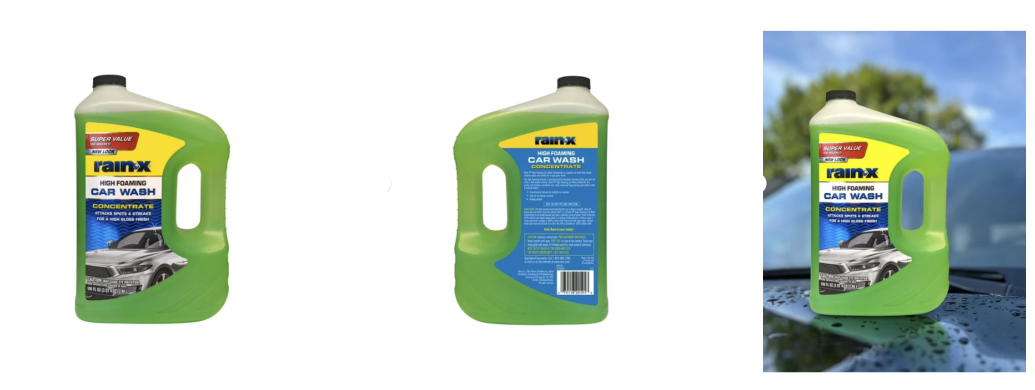

Recontext took 12.86s


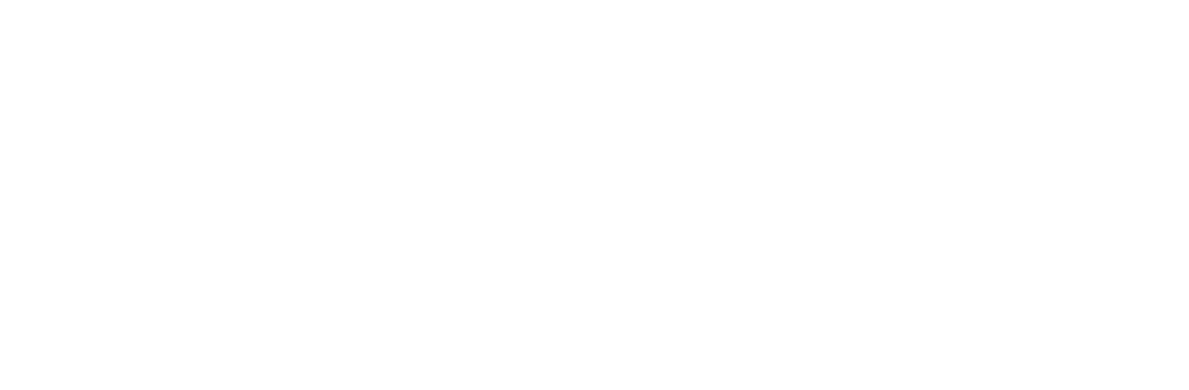

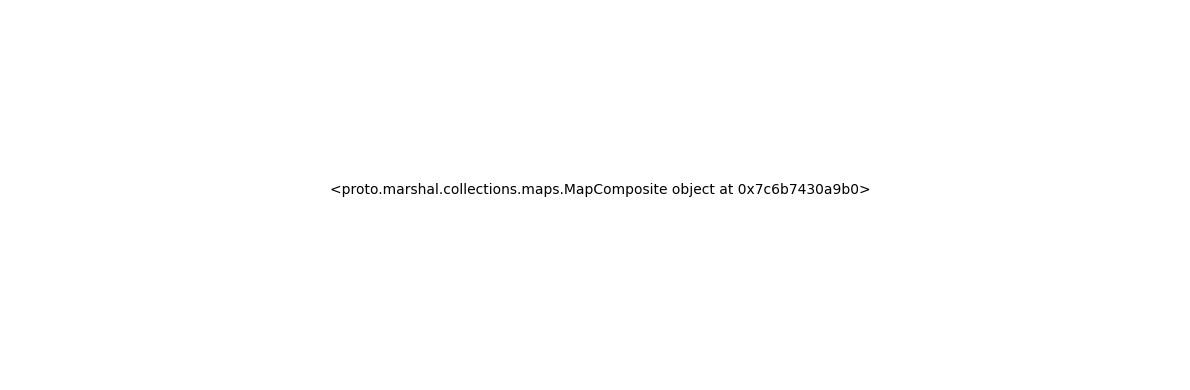

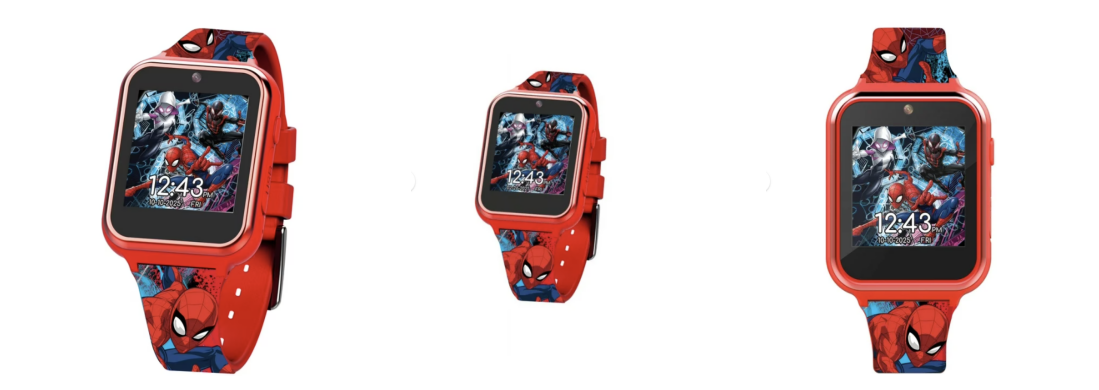

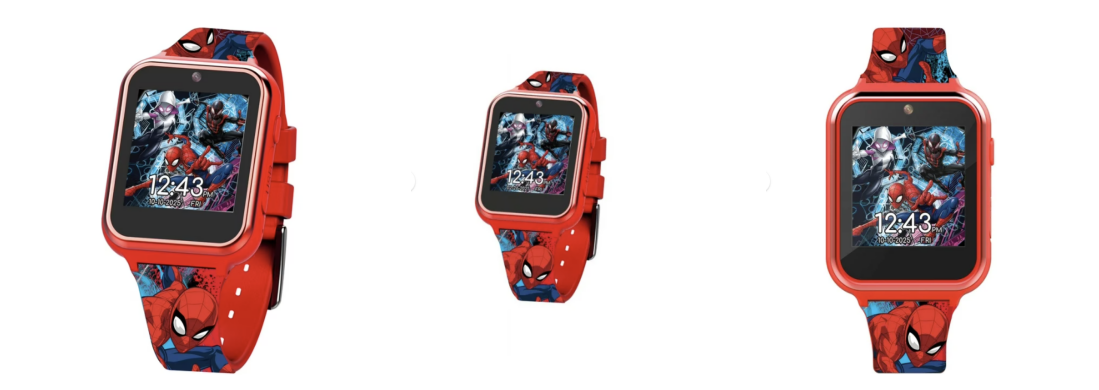

Saved local: product_18_output_0.jpg
Uploaded to gs://id_test_bucket/walmart/product_images_output/product_18/product_18_output_0.jpg

=== Processing product_4 ===


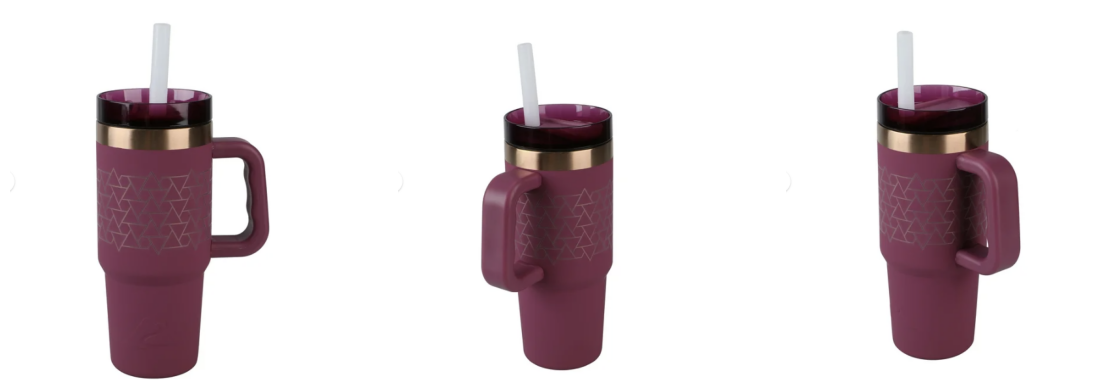

Prompt: A classic black JanSport backpack, made of durable polyester fabric with a slightly textured finish. It features a main compartment, a smaller front utility pocket with a zipper closure, and a side water bottle pocket. The iconic JanSport logo patch is prominently displayed on the front. The backpack has padded shoulder straps and a top grab handle. It is placed on a wooden bench in a sunlit park, with green trees and a walking path in the soft background, suggesting a casual outdoor setting.
Desc:   A classic black JanSport backpack, made of durable polyester fabric with a slightly textured finish. It features a main compartment, a smaller front utility pocket with a zipper closure, and a side water bottle pocket. The iconic JanSport logo patch is prominently displayed on the front. The backpack has padded shoulder straps and a top grab handle.
Prompt: A large, bright lime green plastic jug of Rain-X High Foaming Car Wash Concentrate, featuring a black screw-top lid and an int

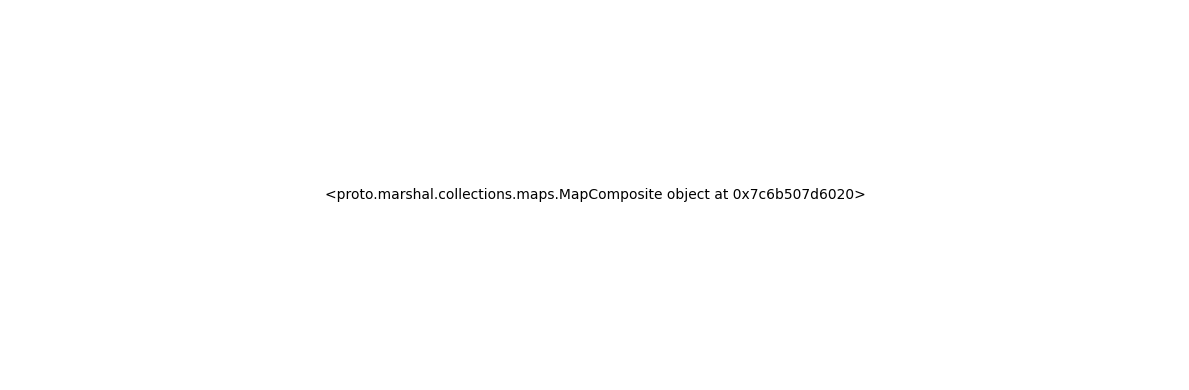

Saved local: product_19_output_0.jpg
Uploaded to gs://id_test_bucket/walmart/product_images_output/product_19/product_19_output_0.jpg

=== Processing product_5 ===


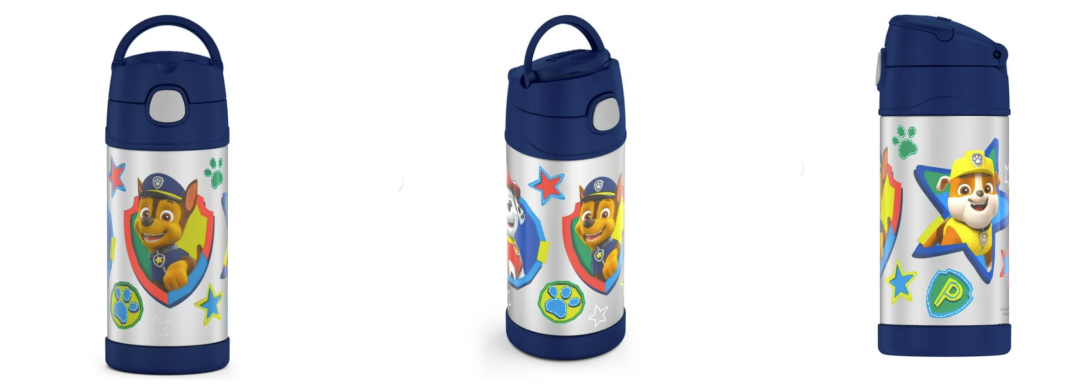

Recontext took 12.49s


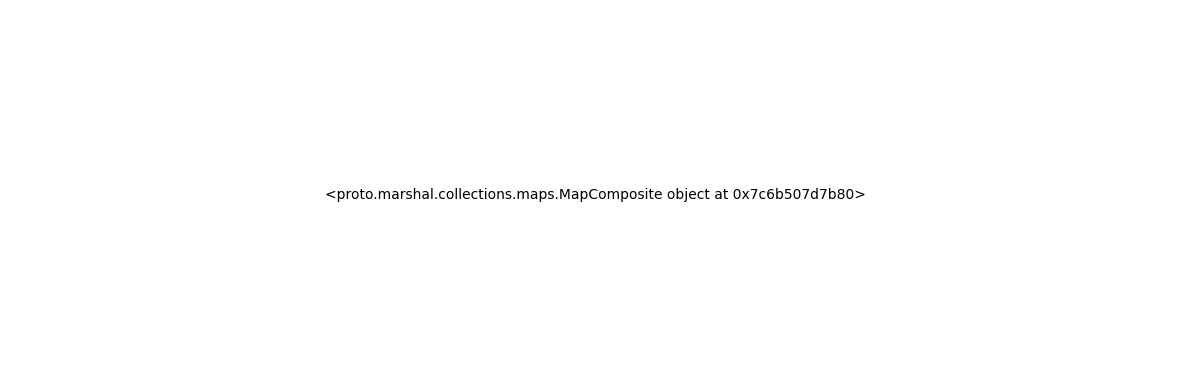

Saved local: product_2_output_0.jpg
Uploaded to gs://id_test_bucket/walmart/product_images_output/product_2/product_2_output_0.jpg

=== Processing product_6 ===
Recontext took 12.47s


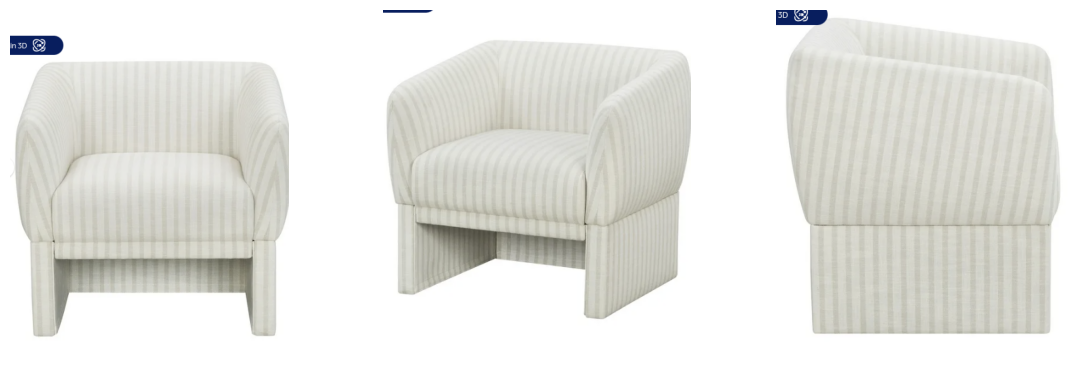

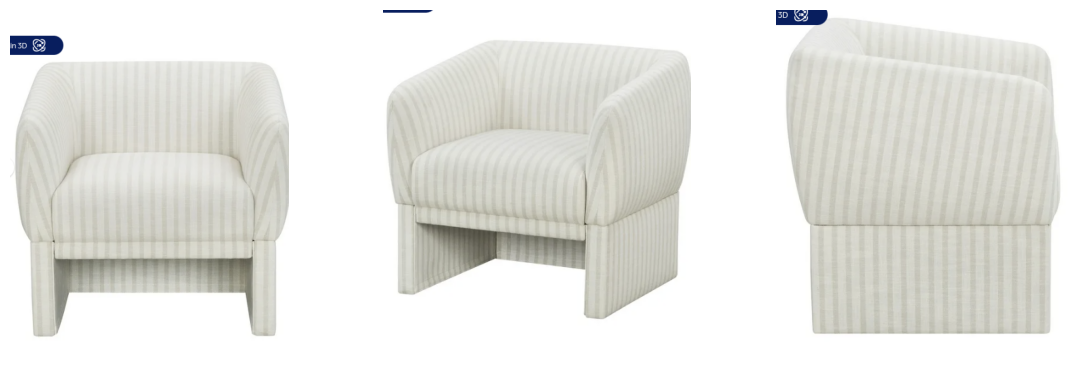

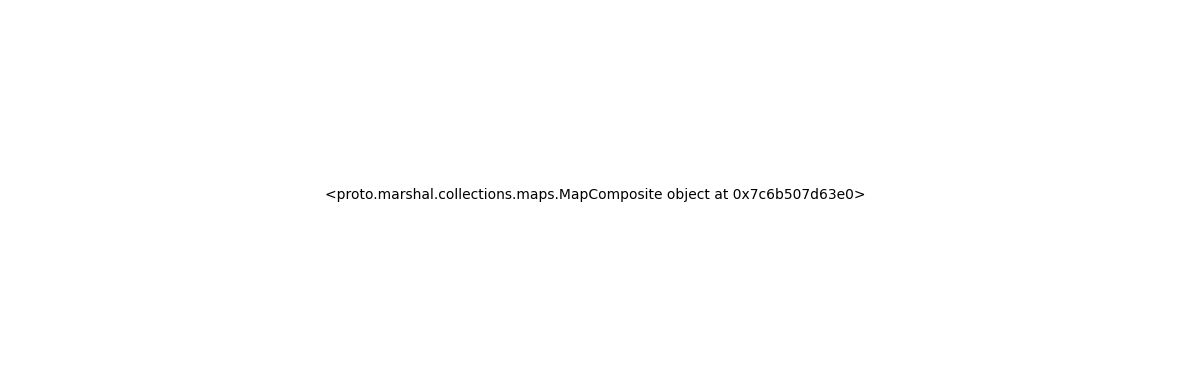

Saved local: product_20_output_0.jpg
Uploaded to gs://id_test_bucket/walmart/product_images_output/product_20/product_20_output_0.jpg

=== Processing product_7 ===
Recontext took 11.03s


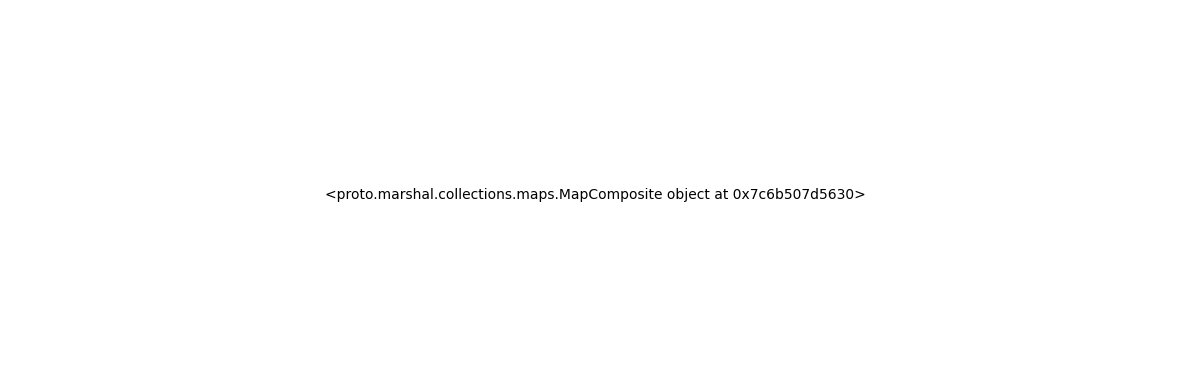

Saved local: product_4_output_0.jpg
Prompt: A stainless steel insulated water bottle for children, featuring a vibrant Paw Patrol character design. The bottle has a silver body adorned with colorful cartoon graphics of characters like Chase and Rubble, along with paw prints and stars. It has a dark blue plastic top with an integrated handle and a push-button straw mechanism. The base is also dark blue plastic. The bottle is placed on a picnic blanket in a sunny park, surrounded by a lunchbox and a small backpack, with green grass and trees in the background.
Desc:   A stainless steel insulated water bottle for children, featuring a vibrant Paw Patrol character design. The bottle has a silver body adorned with colorful cartoon graphics of characters like Chase and Rubble, along with paw prints and stars. It has a dark blue plastic top with an integrated handle and a push-button straw mechanism. The base is also dark blue plastic.
Uploaded to gs://id_test_bucket/walmart/product_images_ou

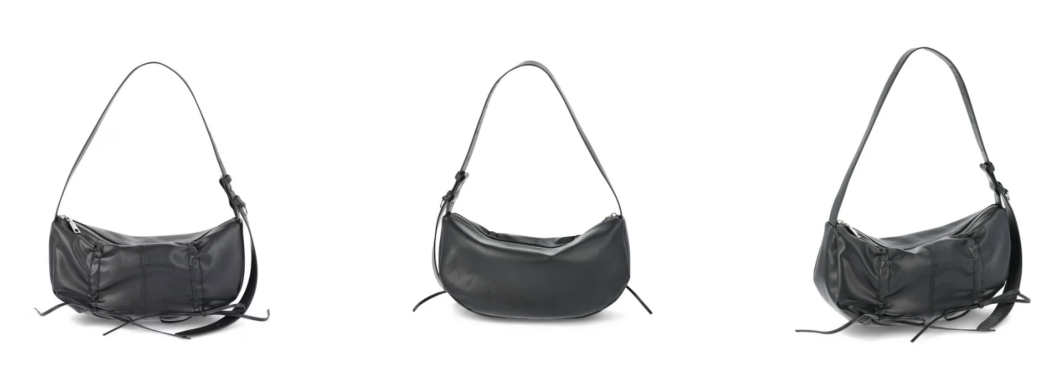

Recontext took 12.44s


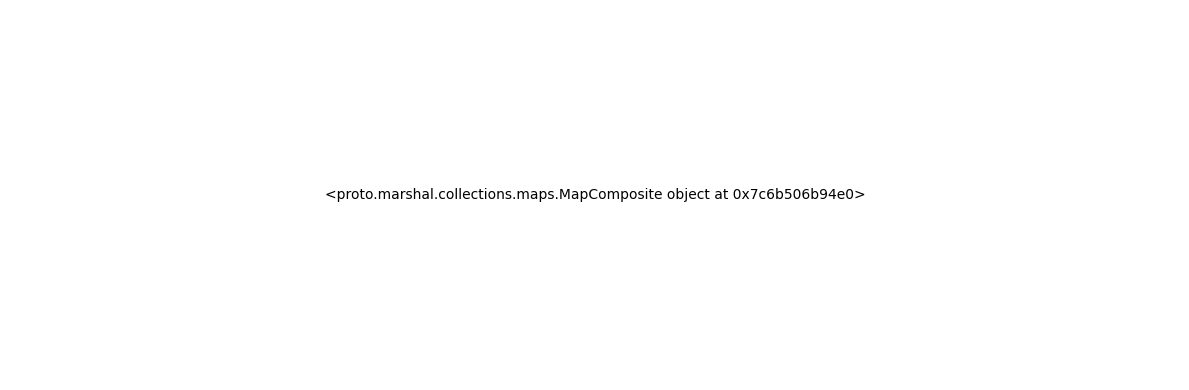

Saved local: product_3_output_0.jpg
Uploaded to gs://id_test_bucket/walmart/product_images_output/product_3/product_3_output_0.jpg

=== Processing product_9 ===
Prompt: A contemporary club chair upholstered in a cream and light beige striped fabric, featuring a rounded back and arms that flow seamlessly into a boxy, skirted base. The chair is positioned in a bright, minimalist living room with natural light streaming through large windows, complemented by light oak flooring and a simple, abstract art piece on the wall.
Desc:   A contemporary club chair upholstered in a cream and light beige striped fabric, featuring a rounded back and arms that flow seamlessly into a boxy, skirted base.
Prompt: A single silver metallic thong sandal with a square toe and a flared kitten heel, resting on a polished concrete floor in a minimalist, sun-drenched art gallery, with soft shadows cast by a nearby large abstract sculpture.
Desc:  

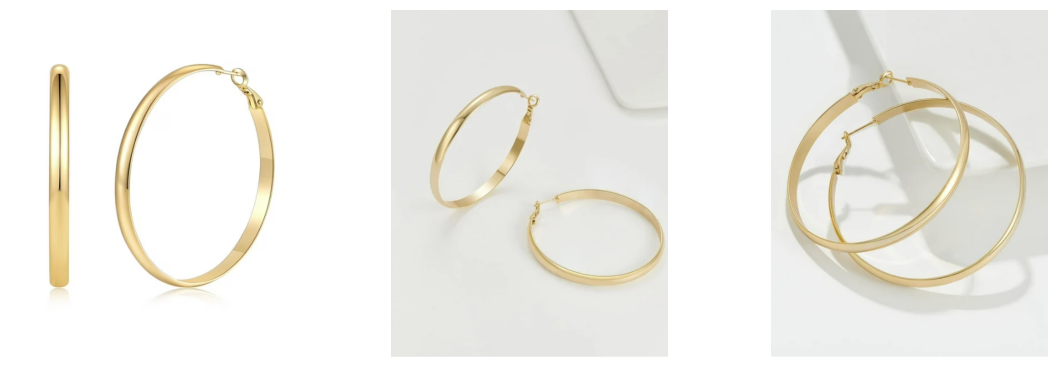

 A single silver metallic thong sandal with a square toe and a flared kitten heel.
Prompt: A sleek, crescent-shaped black faux leather shoulder bag with a soft, slightly ruched texture and a silver-toned zipper closure, featuring adjustable drawstring details on the sides with dangling ties, resting on a minimalist concrete bench in a modern art gallery, bathed in soft, diffused natural light.
Desc:   A sleek, crescent-shaped black faux leather shoulder bag with a soft, slightly ruched texture and a silver-toned zipper closure, featuring adjustable drawstring details on the sides with dangling ties.
Prompt: A pair of elegant, polished gold-tone hoop earrings with a flat, wide band and a classic hinged closure, resting on a velvet jewelry display stand in a luxurious boutique setting, with soft, warm lighting highlighting their metallic sheen.
Desc:   A pair of elegant, polished gold-tone hoop earrings with a flat, wide band and a classic hinged closure.
Recontext took 13.65s


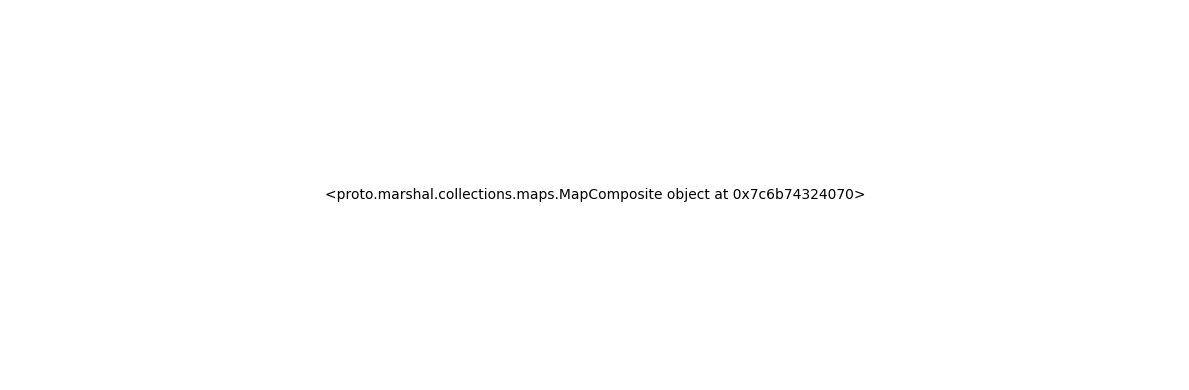

Saved local: product_7_output_0.jpg
Recontext took 14.31s


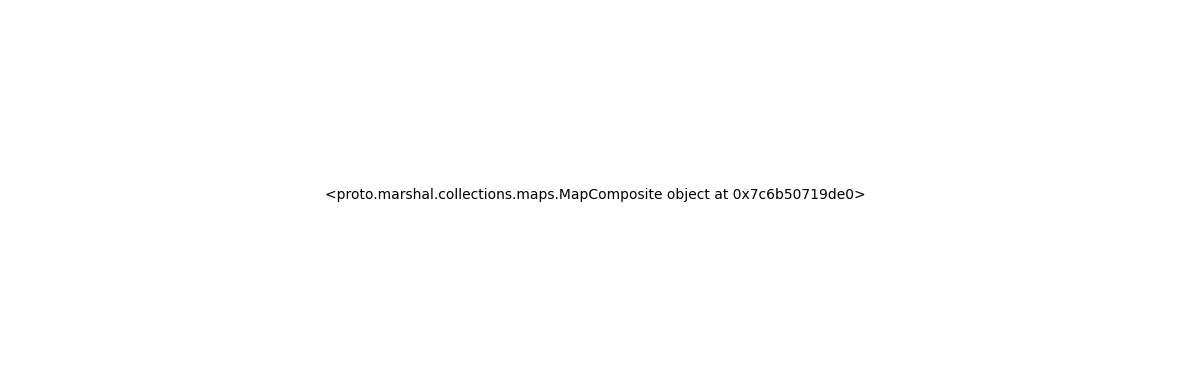

Saved local: product_6_output_0.jpg
Uploaded to gs://id_test_bucket/walmart/product_images_output/product_7/product_7_output_0.jpg
Uploaded to gs://id_test_bucket/walmart/product_images_output/product_6/product_6_output_0.jpg
Recontext took 15.02s


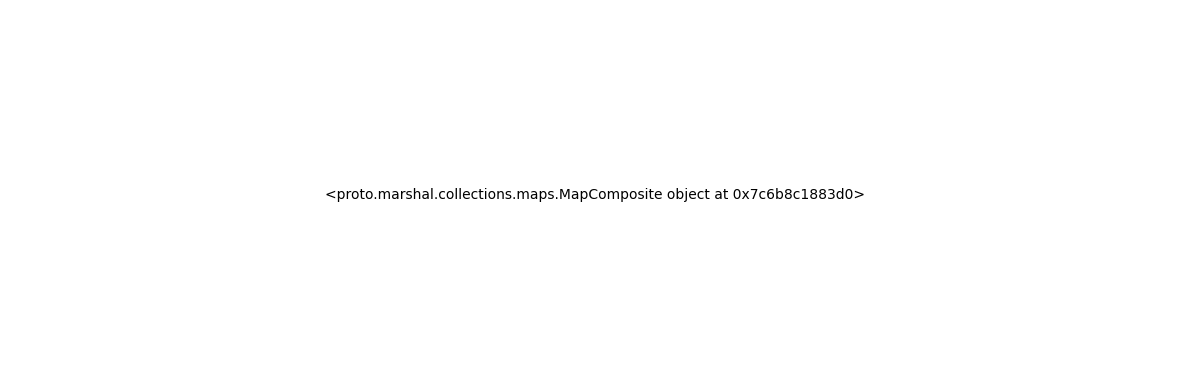

Saved local: product_8_output_0.jpg
Recontext took 13.84s


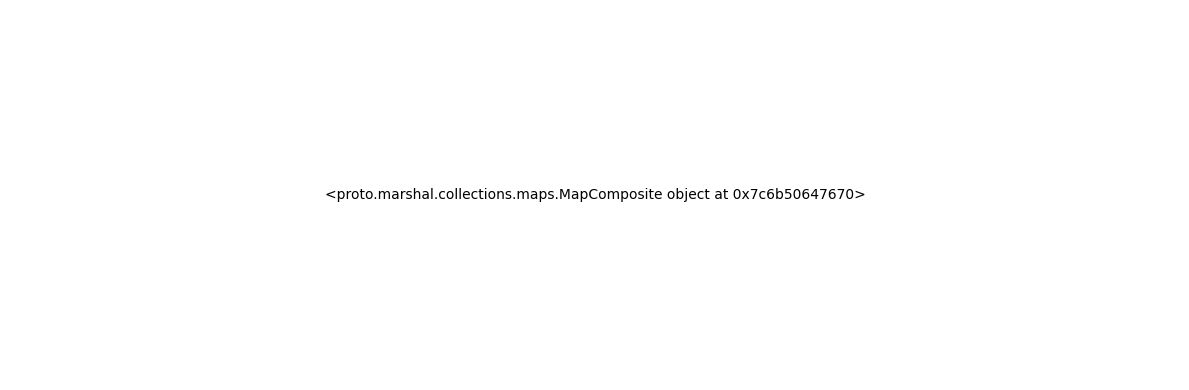

Saved local: product_9_output_0.jpg
Uploaded to gs://id_test_bucket/walmart/product_images_output/product_8/product_8_output_0.jpg
Uploaded to gs://id_test_bucket/walmart/product_images_output/product_9/product_9_output_0.jpg
Recontext took 21.07s


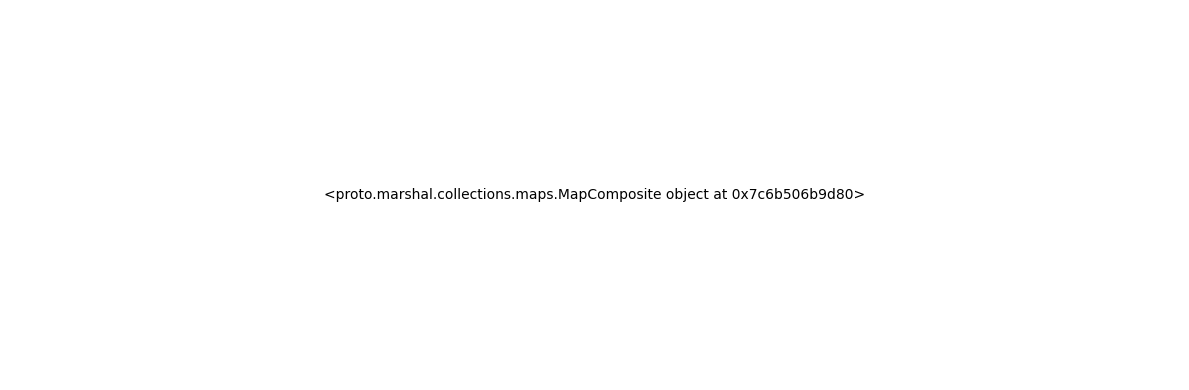

Saved local: product_5_output_0.jpg
Uploaded to gs://id_test_bucket/walmart/product_images_output/product_5/product_5_output_0.jpg

Process completed at: 2025-07-28 16:33:22
Total time taken: 0:01:21.341756


In [ ]:
# Parallel threads

import concurrent.futures
from datetime import datetime  # <-- Added
import io
from PIL import Image

INPUT_PREFIX = "gs://id_test_bucket/walmart/product_images_input"
OUTPUT_BUCKET = "id_test_bucket"
MAX_WORKERS = 5  # Adjust this to control parallelism
#Use max_workers=None in Python 3.8+ to automatically set it to min(32, os.cpu_count() + 4).


# Start time
start_time = datetime.now()
print(f"\n🔄 Process started at: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")

batches = list(discover_product_batches(INPUT_PREFIX))
print(f"\nTotal product folders discovered: {len(batches)}")

if not batches:
    raise RuntimeError("No product batches found—check your GCS path & permissions!")

def process_batch(batch):
    try:
        print(f"\n=== Processing {batch['product_folder']} ===")

        # Preview
        imgs = [Image.open(io.BytesIO(download_gcs_image_bytes(u))) for u in batch["product_uris"]]
        display_row(imgs)

        # Generate prompt & description
        gen = generate(batch["image_parts"])
        print("Prompt:", gen["Prompt"])
        print("Desc:  ", gen["product_description"])

        # Recontextualize
        resp = call_product_recontext(
            prompt=gen["Prompt"],
            product_description=gen["product_description"],
            image_uris_list=batch["product_uris"],
            disable_prompt_enhancement=False,
            sample_count=1,
            safety_setting="block_low_and_above",
            person_generation="allow_adult",
        )

        # Display & upload
        preds = list(resp.predictions)
        display_row(preds)
        for i, p in enumerate(preds):
            save_and_upload_recontext_image(
                p,
                batch["product_folder"],
                OUTPUT_BUCKET,
                image_index=i
            )
    except Exception as e:
        print(f"Error processing batch {batch['product_folder']}: {e}")

# Parallel execution
with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    futures = [executor.submit(process_batch, batch) for batch in batches]
    concurrent.futures.wait(futures)

# End time
end_time = datetime.now()
duration = end_time - start_time
print(f"\nProcess completed at: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Total time taken: {duration}")


In [ ]:
# More threads can run into quota issue with below mentioned error
Error processing batch product_6: 429 Quota exceeded for aiplatform.googleapis.com/online_prediction_requests_per_base_model with base model: imagen-product-recontext-preview. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/generative-ai/quotas-genai.

In [ ]:
#!rm *.jpg

rm: cannot remove '*.jpg': No such file or directory


# Evaluation